<a href="https://colab.research.google.com/github/4datascience/Traffic/blob/master/Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INITIALISATION**

## Files

### Mount \<Google Drive\>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data

Mounted at /content/drive


### Clone \<Github\>

In [4]:
!sh /content/drive/MyDrive/Traffic/scripts/initialisation.sh
%cd /content/Traffic
!git config user.email diego@google.colab.com
!git config user.name "Google Colab"
!git config http.postBuffer 524288000

/content/drive/MyDrive/Traffic/scripts/initialisation.sh: 1: %cd: not found
fatal: destination path 'Traffic' already exists and is not an empty directory.
/content/drive/MyDrive/Traffic/scripts/initialisation.sh: 3: %cd: not found
/content/Traffic


## Python Environment

### Import Python libraries

In [56]:
import os
import pandas as pd
import calendar

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

### SET ENVIRONMENT VARIABLES

In [6]:
# PREDICTION HORIZON
PREDICTED_MINUTES_AHEAD = 5
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")

#**UPLOAD DATA**

## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_Naive_Bayes_{PREDICTED_MINUTES_AHEAD}m_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_Naive_Bayes_{PREDICTED_MINUTES_AHEAD}m_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7387200 elements):
	62.45434623813002%
Validation percentage:
	37.54463923382843%


#**DOWNLOAD DATA**

In [25]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_Naive_Bayes_{PREDICTED_MINUTES_AHEAD}m_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_Naive_Bayes_{PREDICTED_MINUTES_AHEAD}m_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

# DATA EXPLORATION

> Per-link id data balance





In [17]:
training_df[training_df['LOS_dep']==4]['link_id'].value_counts()[training_df.link_id.unique()]

5     28407
6     20875
7     11497
8      8188
9      4173
10    20101
Name: link_id, dtype: int64

> Per weekday link LOS histogram


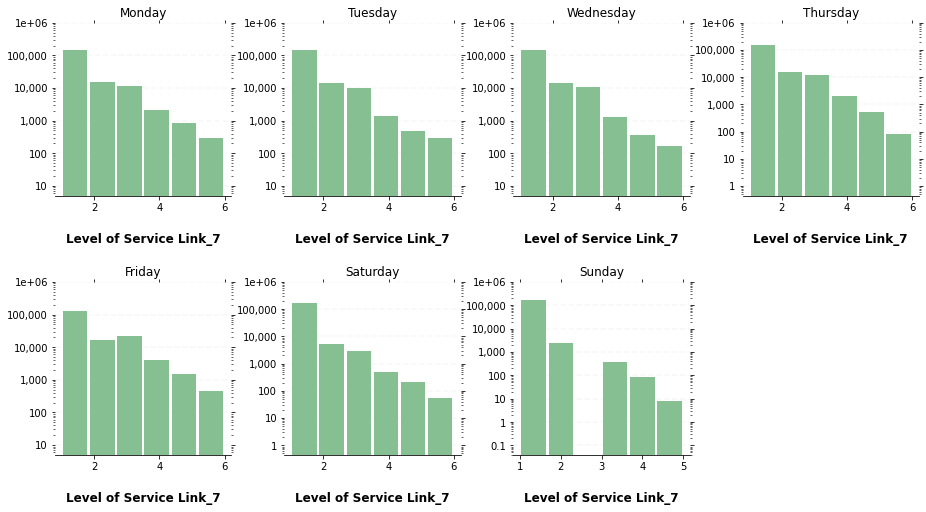

In [61]:
LINK = 7
base_df=training_df[training_df['link_id']==LINK]
plot_df = pd.merge(base_df['LOS_dep'],
pd.DataFrame(list(base_df.index.weekday), index=base_df.index, columns=['weekday']), left_index=True, right_index=True)

# Plot histogram LOS per weekday
ax = plot_df.hist(column='LOS_dep', by=plot_df['weekday'], bins=6, log=True, grid=False, layout=(2,4), figsize=(15,8), color='#86bf91', zorder=2, rwidth=0.9)

for x_col in ax:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"Level of Service Link_{LINK}", labelpad=20, weight='bold', size=12)

            # Format y-axis label
            x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

            # Set title
            x.set_title(calendar.day_name[int(x.get_title())])

            x.tick_params(axis='x', rotation=0)

# **NAIVE BAYES**

## **NO FEATURE ENGINEERING**

# **CLEAN UP**

In [52]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


## COMMIT AND REMOVE

In [62]:
!sh /content/drive/MyDrive/Traffic/scripts/logout.sh
drive.flush_and_unmount()

/content/drive/MyDrive/Traffic/scripts/logout.sh: 1: %cd: not found
fatal: pathspec '.?' did not match any files
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Everything up-to-date


In [63]:
!rm -rf /content/Traffic